# TETRA Modulation Experiments

This notebook contains part of the TETRA modulation pipeline. Specifically, the type5 bits → symbols → modulated, filtered signal flow.

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from commpy.filters import rrcosfilter
from modulator import Modulator
from bitarray import bitarray

one symbol is 0.000056 seconds
one symbol is 11 samples
the filter is 88 samples / 8 symbols / 0.444444ms long


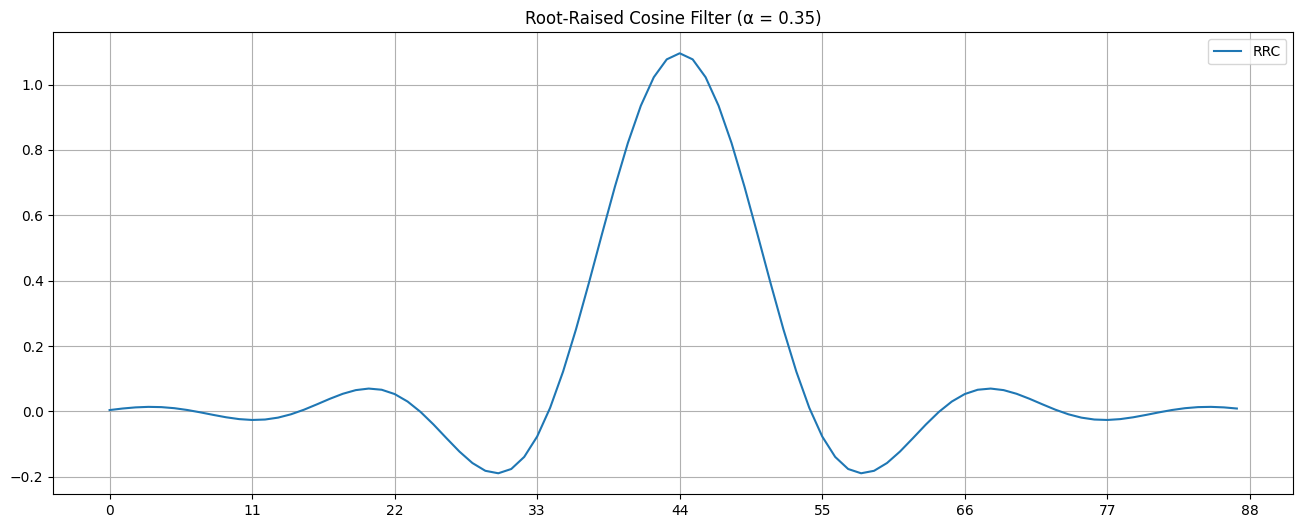

In [2]:
# Master sample rate
samp_rate = 200000

# Rolloff factor of the filter (α)
alpha = 0.35

# Symbol is 500/9µS long
sym_sec = (500 / 9) * 1e-6 
print('one symbol is %f seconds' % sym_sec)

# Calculate the number of samples in a symbol
sym_samples = round(samp_rate * sym_sec)
print('one symbol is %d samples' % sym_samples)

# Span of the filter in symbols
span = 8

# Design a root-raised cosine filter
time_idx, h_rrc = rrcosfilter(sym_samples * span, alpha, sym_sec, samp_rate)

# Transient length in samples for the filter
# In 'full' convolution mode, the output is the sum of the lengths of the input sequences minus 1
# Thus we start at half of the filter length
filter_trans_len = len(h_rrc) // 2

print('the filter is %d samples / %d symbols / %fms long' % (
    len(h_rrc),
    len(h_rrc) / sym_samples,
    sym_sec * len(h_rrc) / sym_samples * 1000
))

plt.figure()
plt.title('Root-Raised Cosine Filter (α = %.2f)' % alpha)

# Set the x ticks to be the symbol rate
plt.xticks(np.arange(0, len(h_rrc) + 1, sym_samples))

# Show a grid
plt.grid()

# Plot
plot = plt.plot(h_rrc, label='RRC')

# Show legend
plt.legend(handles=[plot[0]])
plt.gcf().set_size_inches(16, 6)

Generated 256 symbols from 510 bits


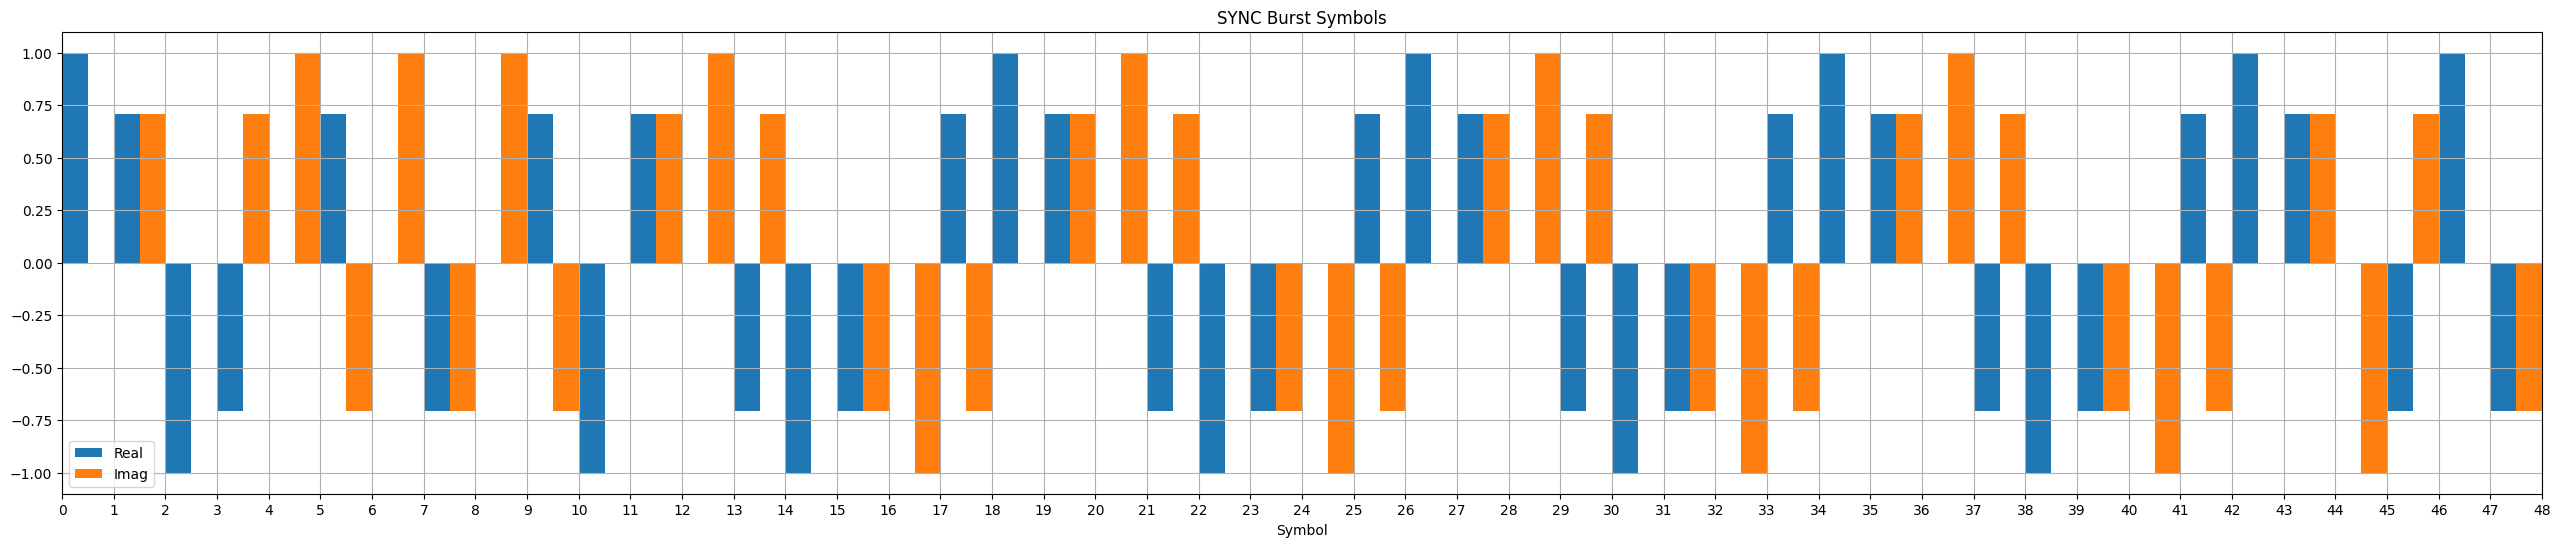

In [3]:
import example_bursts

# Use the modulator to produce some symbols from input bits
# bits = bitarray(random.choice([0, 1]) for _ in range(256))
bits = example_bursts.SYNC_BURST
symbols = np.array(Modulator.encode(bits))
indices = np.arange(0, len(symbols), dtype=float)
print(f"Generated {len(symbols)} symbols from {len(bits)} bits")

# Plot them as grouped bars
series = ("I", "Q")
width = 0.5

plt.figure()


# Set the x ticks to be the symbol rate
plt.xticks(np.arange(0, len(symbols), 1))

# Set the x title
plt.xlabel('Symbol')

plt.grid()
plt.title('SYNC Burst Symbols')

plt.bar(indices, symbols.real, label='Real', align='edge', width=width)
indices += width
plt.bar(indices, symbols.imag, label='Imag', align='edge', width=width)

plt.legend()
plt.xlim(0, 48)
plt.gcf().set_size_inches(32, 6)


In [ ]:
# Expand each symbol to be sym_samples long, with the first sample taking the value of the symbol
# The rest of the samples are zero
expanded_symbols = np.zeros(len(symbols) * sym_samples, dtype=complex)
for i in range(len(symbols)):
    expanded_symbols[i * sym_samples] = symbols[i]
print("Generated expanded symbol samples: ", len(expanded_symbols))
    

Generated expanded symbol samples:  2816
(1+0j)
0j
0j
0j
0j
0j
0j
0j
0j
0j


In [5]:
# Apply the pulse shaping filter
print("Filter has tap count:", len(h_rrc))
samples = np.convolve(expanded_symbols, h_rrc, mode='full')
print("Convolved samples: ", len(samples))

Filter has tap count: 88
Convolved samples:  2903


In [6]:
# We will slice the filter transient from the start and end of the filtered symbols
samples_with_filter_transient = np.copy(samples)
samples = samples[filter_trans_len:-filter_trans_len]
print("Trimmed symbols: ", len(samples))

Trimmed symbols:  2815


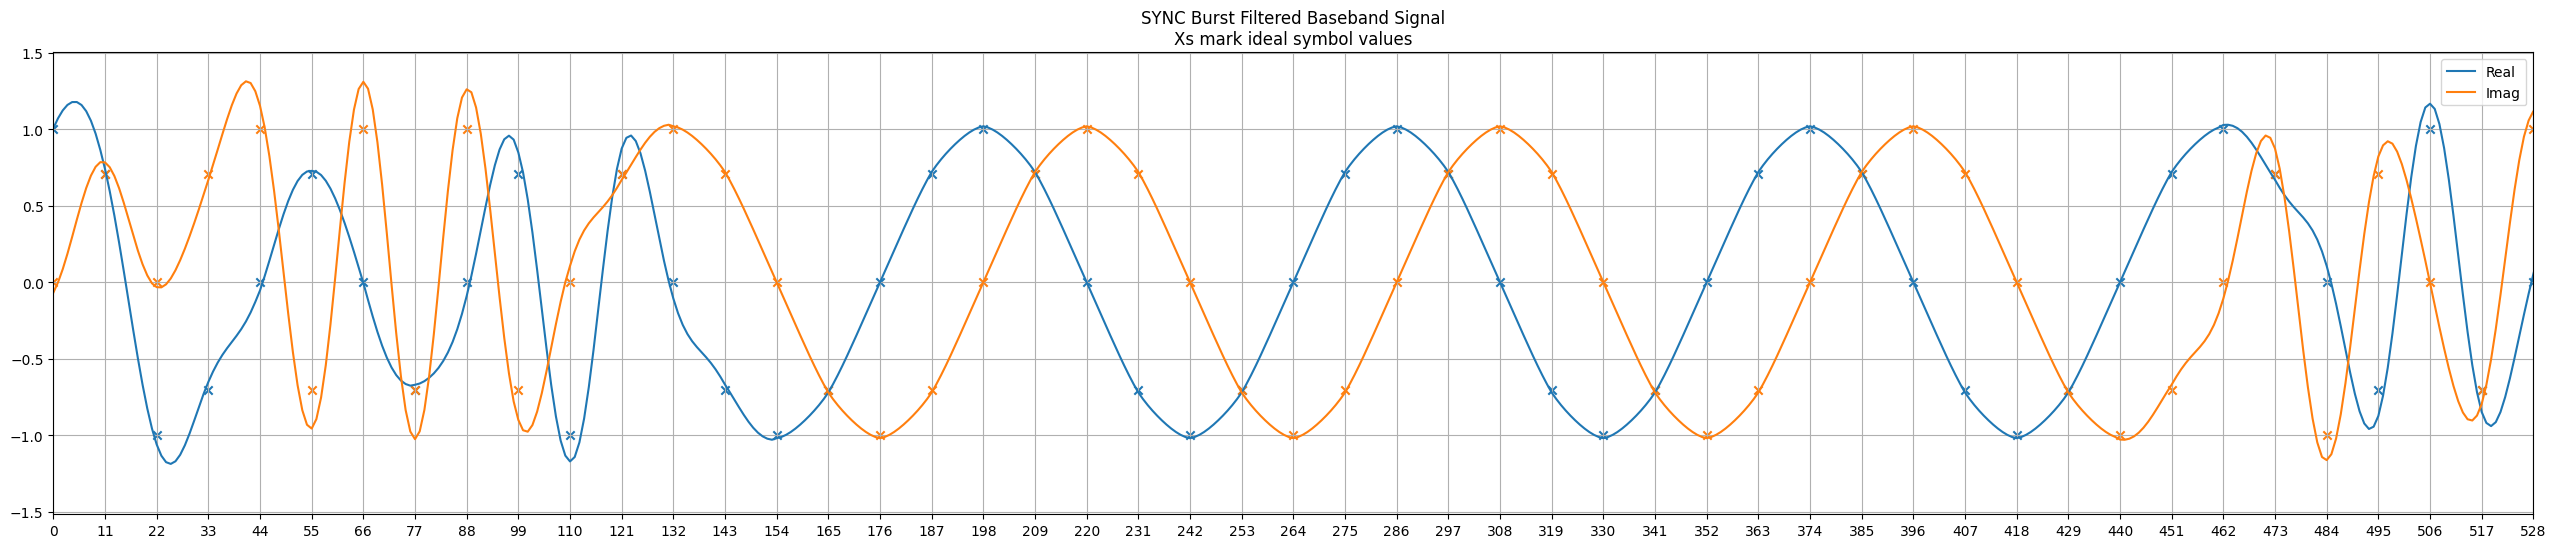

In [7]:
# Plot the filtered symbols
plt.figure()
plt.grid()

# Plot the symbol peaks
for i in enumerate(range(0, len(samples), sym_samples)):

    # Also plot this symbol
    plt.scatter([i[1]], [symbols.real[i[0]]], color='C0', marker='x')
    plt.scatter([i[1]], [symbols.imag[i[0]]], color='C1', marker='x')


# Set the x ticks to be the symbol rate
plt.xticks(np.arange(0, len(samples) + 1, sym_samples))

plt.title(f"SYNC Burst Filtered Baseband Signal\nXs mark ideal symbol values")
filt_sym_real = plt.plot(samples.real, label='Real')
filt_sym_imag = plt.plot(samples.imag, label='Imag')

plt.xlim(0, sym_samples * 48)

# Add legend
plt.legend(handles=[filt_sym_real[0], filt_sym_imag[0]])

# Make the plot horizontally larger
plt.gcf().set_size_inches(32, 6)

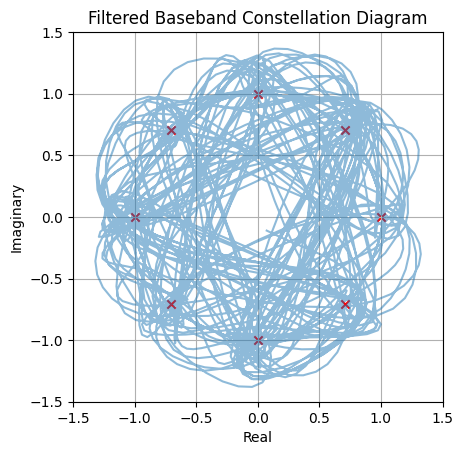

In [8]:
# Plot a cartesian constellation diagram of the symbols
plt.figure()
plt.grid()
plt.title("Filtered Baseband Constellation Diagram")

# Plot the filtered symbols
plt.plot(
    samples.real, 
    samples.imag,
    alpha=0.5,
)

plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

# Make the plot square
plt.gca().set_aspect('equal', adjustable='box')

# Plot the ideal symbol locations
ideal_symbols = np.array(Modulator.SYMBOL_IQ_MAPPING)
plt.scatter(ideal_symbols.real, ideal_symbols.imag, color='red', marker='x')

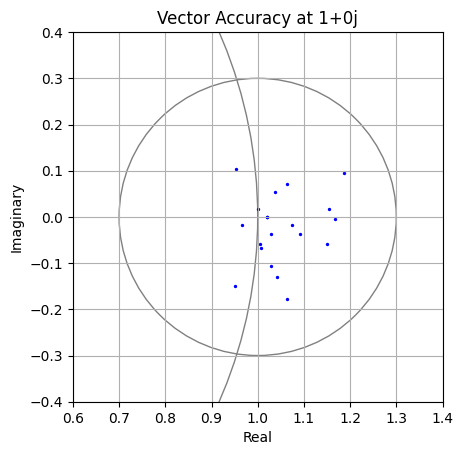

In [9]:
# Plot a zoomed in view of one constellation point
const_point = (1, 0)
zoom_range = 0.4

plt.figure()
plt.grid()
plt.title("Vector Accuracy at %d+%dj" % const_point)

# Draw the unit circle
circle = plt.Circle((0, 0), 1, color='grey', fill=False)
plt.gca().add_artist(circle)

# Draw a 0.6 radius circle around the zoomed constellation point
circle = plt.Circle(const_point, 0.3, color='grey', fill=False)
plt.gca().add_artist(circle)

# Plot the symbol peaks
symbol_peaks = np.array([])
for i in range(0, len(samples), sym_samples):
    symbol_peaks = np.append(symbol_peaks, samples[i])
plt.scatter(symbol_peaks.real, symbol_peaks.imag, color='blue', s=2)

plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.xlim(const_point[0] - zoom_range, const_point[0] + zoom_range)
plt.ylim(const_point[1] - zoom_range, const_point[1] + zoom_range)



# Make the plot square
plt.gca().set_aspect('equal', adjustable='box')

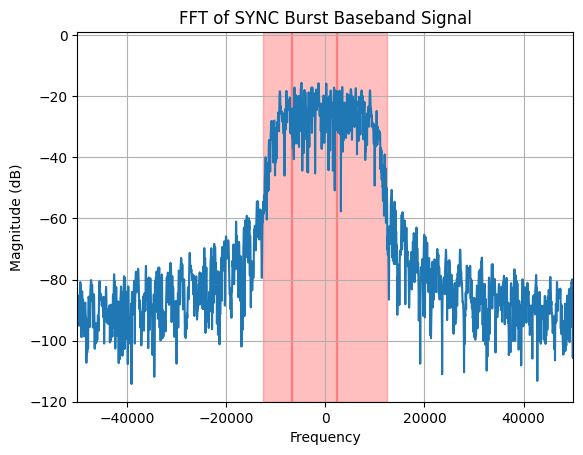

In [10]:
# Now we'll take the FFT of the filtered signal
plt.figure()
plt.magnitude_spectrum(samples_with_filter_transient, Fs=samp_rate, scale='dB', color='C0', pad_to=8192)
plt.grid()
plt.title("FFT of SYNC Burst Baseband Signal")
plt.xlim(-50000, 50000)
plt.ylim(-120, 1)

# Plot a band of interest
plt.fill_between([-12500, 12500], -120, 1, color='red', alpha=0.25)

# Highlight some interesting frequencies
above_carrier = 2250
plt.fill_between([above_carrier-100, above_carrier+100], -120, 1, color='red', alpha=0.25)

below_carrier = -6750
plt.fill_between([below_carrier-100, below_carrier+100], -120, 1, color='red', alpha=0.25)

Got 2815 samples
Plotting 4 symbols per pass
Plotting 44 samples per pass based on 11 samples per symbol
Plotting 63 passes
Resized to 2772 samples
(63, 44)


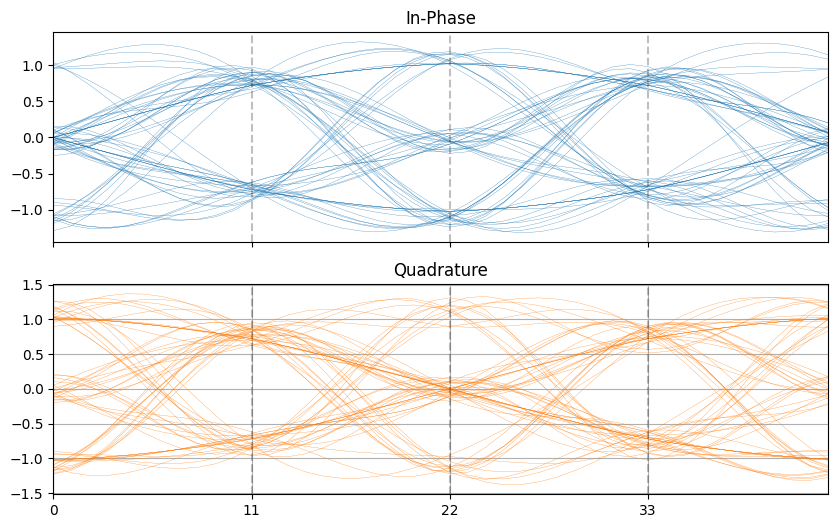

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

# Plot this many symbols worth of samples per pass
eye_diag_samples = samples
print('Got %d samples' % len(eye_diag_samples))

symbols_to_plot = 4
print('Plotting %d symbols per pass' % symbols_to_plot)

samples_per_pass = sym_samples * symbols_to_plot
print('Plotting %d samples per pass based on %d samples per symbol' % (samples_per_pass, sym_samples))

number_of_passes = len(eye_diag_samples) // samples_per_pass
print('Plotting %d passes' % number_of_passes)

# Drop excess samples
eye_diag_samples = np.resize(eye_diag_samples, number_of_passes * samples_per_pass)
print('Resized to %d samples' % len(eye_diag_samples))

# Split the data into passes
passes = np.array(np.array_split(eye_diag_samples, number_of_passes))
print(passes.shape)

# Get the real parts of the list of arrays of complex values
fig, [real, imag] = plt.subplots(nrows=2, ncols=1, sharex=True)
real.set_title('In-Phase')
imag.set_title('Quadrature')

# Plot the real & imag part of the signal
real.plot(passes.T.real, color='C0', alpha=1, lw=.2)
imag.plot(passes.T.imag, color='C1', alpha=1, lw=.2)

# Plot a vertical line at each symbol
for i in range(0, samples_per_pass, sym_samples):
    real.axvline(x=i, color='black', linestyle='--', alpha=0.25, label='Symbol Peak')
    imag.axvline(x=i, color='black', linestyle='--', alpha=0.25)

# Set the x ticks to be the symbol rate
plt.xticks(np.arange(0, len(samples) + 1, sym_samples))

# Make the plot horizontally larger
plt.xlim(0, samples_per_pass - 1)
plt.grid()
plt.gcf().set_size_inches(10, 6)